In [1]:
"""Calculate correlations between learned and known features."""

'Calculate correlations between learned and known features.'

In [2]:
# define desired model, model layer, and window size for analysis

model_acc = "7_1_2" # ["3_6_1", "6_2", "7_1_2", "7_2_2", "7_3_2"]
layer_name = "conv1d2"
known_window = 10 # [10,20,30,40,50]

In [3]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import src.models.utils
import src.utils
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams.update({'figure.autolayout': True})

class MaskedConv1D(tf.keras.layers.Conv1D):
    def __init__(self, filters, kernel_size, **kwargs):
        super().__init__(filters, kernel_size, **kwargs)
        self.supports_masking = True
        
class TreeNode:
    def __init__(self, name=None, children=None):
        self.name = name
        self.children = children if children is not None else []
               
def make_tree(lm):
    num_tips = len(lm) + 1
    nodes = {node_id: TreeNode(name=node_id, children=[]) for node_id in range(num_tips)}
    heights = {node_id: 0 for node_id in range(2*num_tips-1)}
    for idx in range(len(lm)):
        node_id = idx + num_tips
        child_id1, child_id2, distance, _ = lm[idx]
        child1, child2 = nodes[child_id1], nodes[child_id2]
        height1, height2 = heights[child_id1], heights[child_id2]
        child1.length = distance - height1
        child2.length = distance - height2
        parent = TreeNode(name=node_id, children=[child1, child2])
        nodes[node_id] = parent
        heights[node_id] = distance
    tree = nodes[2*(num_tips-1)]
    return tree

def get_tip_order(tree):
    tip_order = []
    stack = [tree]
    while stack:
        node = stack.pop()
        if node.children:
            stack.extend(node.children)
        else:
            tip_order.append(node.name)
    return tip_order

In [4]:
alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
weights = {'0': 1, '1': 2, '-': 3}
batch_size = 32

batch_data = src.models.utils.load_data('../../mobidb-pdb_validation/split_data/out/all_seqs.fasta', 
                                        '../../mobidb-pdb_validation/split_data/out/all_labels.fasta')

batches = src.models.utils.BatchGenerator(batch_data, batch_size, alphabet, weights,
                                          shuffle=False, all_records=True)

seq_fasta = src.utils.read_fasta('../../mobidb-pdb_validation/split_data/out/all_seqs.fasta')

known_feature_dir = f"../generate_maps/out/window_size{known_window}"

# load in names of known features from first file in known_feature_dir
known_feature_names = np.loadtxt(f"{known_feature_dir}/{os.listdir(known_feature_dir)[0]}", dtype = str, max_rows = 1)

# Extract accessions
protein_acc = []
for accession, _, in seq_fasta:
    protein_acc.append(accession.split("|")[0][1:]) # Keep only acc

In [5]:
# Calculate learned features
model_name = f"mobidb-pdb_cnn_{model_acc}"
model_path = f"../../models/{model_name}_re/out_model/"

model_untrained = tf.keras.models.load_model(f"{model_path}{model_name}_re_untrained.h5",
                                           custom_objects={"MaskedConv1D":MaskedConv1D})
model_trained = tf.keras.models.load_model(f"{model_path}{model_name}_re_trained.h5",
                                           custom_objects={"MaskedConv1D":MaskedConv1D})

untrained_layer = model_untrained.get_layer(layer_name)
trained_layer = model_trained.get_layer(layer_name)

untrained_feature_extractor = tf.keras.Model(inputs=model_untrained.inputs, outputs=untrained_layer.output)
trained_feature_extractor = tf.keras.Model(inputs=model_trained.inputs, outputs=trained_layer.output)
    
untrained_learned_features = []
trained_learned_features = []
for input, _, training_weights, in batches:  # Predict method was acting strange, so extract individual batches
    untrained_features = untrained_feature_extractor(input).numpy()
    trained_features = trained_feature_extractor(input).numpy()
    
    untrained_features = untrained_features[training_weights != 0]  # Drop padding
    trained_features = trained_features[training_weights != 0]
    
    untrained_learned_features.append(untrained_features)
    trained_learned_features.append(trained_features)

In [6]:
# Construct matrices of learned feature values
untrained_learned_feature_array = [array for array in untrained_learned_features]
untrained_learned_feature_array = np.concatenate(untrained_learned_feature_array, axis = 0)
untrained_learned_feature_array = untrained_learned_feature_array.transpose()

trained_learned_feature_array = [array for array in trained_learned_features]
trained_learned_feature_array = np.concatenate(trained_learned_feature_array, axis = 0)
trained_learned_feature_array = trained_learned_feature_array.transpose()

In [7]:
# Load in known features
known_features = []
for acc in protein_acc:
    acc_path = f"{known_feature_dir}/{acc}_feature_map{known_window}.tsv"
    protein_known_features = np.loadtxt(acc_path, skiprows = 1)
    known_features.append(protein_known_features)

In [8]:
# Construct matrix of known feature values
known_feature_array = [array for array in known_features]
known_feature_array = np.concatenate(known_feature_array, axis = 0)
known_feature_array = known_feature_array.transpose()

In [9]:
# Calculate correlation between known and learned features
untrained_corr_matrix = np.corrcoef(untrained_learned_feature_array, known_feature_array)
untrained_corr_matrix = untrained_corr_matrix[:len(untrained_learned_feature_array), -len(known_feature_array):]

trained_corr_matrix = np.corrcoef(trained_learned_feature_array, known_feature_array)
trained_corr_matrix = trained_corr_matrix[:len(trained_learned_feature_array), -len(known_feature_array):]

diff_corr_matrix = trained_corr_matrix - untrained_corr_matrix

In [10]:
# Identify constant learned features with NaN correlations
nan_rows = []
nonnan_rows = []
for i, isnan in enumerate(np.any(np.isnan(diff_corr_matrix.transpose()), axis=0)):
    if isnan:
        nan_rows.append(i)
    else:
        nonnan_rows.append(i)
        
# Sort learned and known features by correlation hierarchy
nan_array = diff_corr_matrix[nan_rows]
nonnan_array = diff_corr_matrix[nonnan_rows]

learned_cdm = pdist(nonnan_array, metric='correlation')
learned_lm = linkage(learned_cdm, method='average')
learned_tree = make_tree(learned_lm)
learned_tip_order = get_tip_order(learned_tree)

known_cdm = pdist(nonnan_array.transpose(), metric='correlation')
known_lm = linkage(known_cdm, method='average')
known_tree = make_tree(known_lm)
known_tip_order = get_tip_order(known_tree)

array = nonnan_array[learned_tip_order]
cluster_x_array = np.concatenate([array, nan_array], axis=0)  # Combine sorted non-NaN and NaN features

array = array.transpose()[known_tip_order].transpose()
cluster_xy_array = np.concatenate([array, nan_array], axis=0)  # Combine sorted non-NaN and NaN features

vext = np.nanmax(np.abs(array))

# Identify constant learned trained features with NaN correlations
trained_nan_rows = []
trained_nonnan_rows = []
for i, isnan in enumerate(np.any(np.isnan(trained_corr_matrix.transpose()), axis=0)):
    if isnan:
        trained_nan_rows.append(i)
    else:
        trained_nonnan_rows.append(i)
        
# Sort learned and known trained features by correlation hierarchy
trained_nan_array = trained_corr_matrix[trained_nan_rows]
trained_nonnan_array = trained_corr_matrix[trained_nonnan_rows]

trained_learned_cdm = pdist(trained_nonnan_array, metric='correlation')
trained_learned_lm = linkage(trained_learned_cdm, method='average')
trained_learned_tree = make_tree(trained_learned_lm)
trained_learned_tip_order = get_tip_order(trained_learned_tree)

trained_known_cdm = pdist(trained_nonnan_array.transpose(), metric='correlation')
trained_known_lm = linkage(trained_known_cdm, method='average')
trained_known_tree = make_tree(trained_known_lm)
trained_known_tip_order = get_tip_order(trained_known_tree)

trained_array = trained_nonnan_array[trained_learned_tip_order]
trained_cluster_x_array = np.concatenate([trained_array, trained_nan_array], axis=0)  # Combine sorted non-NaN and NaN features

trained_array = trained_array.transpose()[trained_known_tip_order].transpose()
trained_cluster_xy_array = np.concatenate([trained_array, trained_nan_array], axis=0)  # Combine sorted non-NaN and NaN features

trained_vext = np.nanmax(np.abs(trained_array))

# Identify constant learned untrained features with NaN correlations
untrained_nan_rows = []
untrained_nonnan_rows = []
for i, isnan in enumerate(np.any(np.isnan(untrained_corr_matrix.transpose()), axis=0)):
    if isnan:
        untrained_nan_rows.append(i)
    else:
        untrained_nonnan_rows.append(i)

# Sort learned and known untrained features by correlation hierarchy
untrained_nan_array = untrained_corr_matrix[untrained_nan_rows]
untrained_nonnan_array = untrained_corr_matrix[untrained_nonnan_rows]

untrained_learned_cdm = pdist(untrained_nonnan_array, metric='correlation')
untrained_learned_lm = linkage(untrained_learned_cdm, method='average')
untrained_learned_tree = make_tree(untrained_learned_lm)
untrained_learned_tip_order = get_tip_order(untrained_learned_tree)

untrained_known_cdm = pdist(untrained_nonnan_array.transpose(), metric='correlation')
untrained_known_lm = linkage(untrained_known_cdm, method='average')
untrained_known_tree = make_tree(untrained_known_lm)
untrained_known_tip_order = get_tip_order(untrained_known_tree)

untrained_array = untrained_nonnan_array[untrained_learned_tip_order]
untrained_cluster_x_array = np.concatenate([untrained_array, untrained_nan_array], axis=0)  # Combine sorted non-NaN and NaN features

untrained_array = untrained_array.transpose()[untrained_known_tip_order].transpose()
untrained_cluster_xy_array = np.concatenate([untrained_array, untrained_nan_array], axis=0)  # Combine sorted non-NaN and NaN features

untrained_vext = np.nanmax(np.abs(untrained_array))

vext = max(vext, trained_vext, untrained_vext)

In [11]:
# Make directory to save heat maps
if not os.path.exists('out/'):
    os.mkdir('out/')

if not os.path.exists(f'out/{model_name}_re/'):
    os.mkdir(f'out/{model_name}_re/')

if not os.path.exists(f'out/{model_name}_re/win{known_window}/'):
    os.mkdir(f'out/{model_name}_re/win{known_window}/')

save_path = f'out/{model_name}_re/win{known_window}/'

c:\users\jason hong\appdata\local\programs\python\python38\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


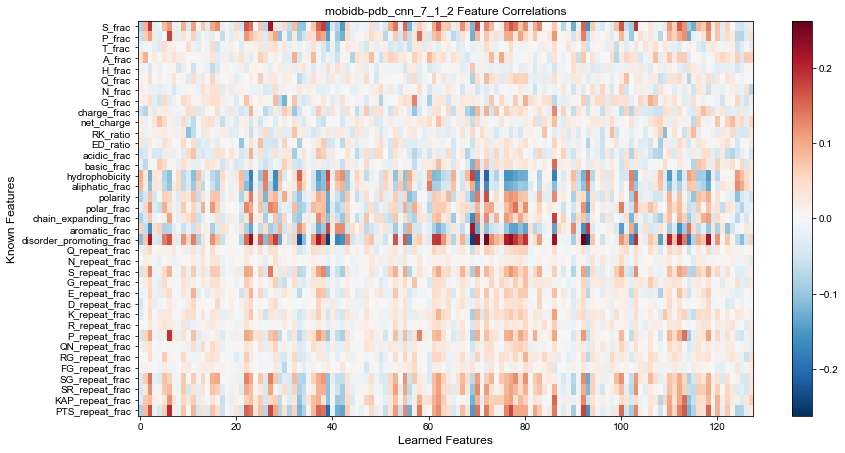

In [12]:
# Plot unclustered results
fig, ax = plt.subplots(figsize=(12.8, 6.4))
im = ax.imshow(diff_corr_matrix.transpose(), vmin=-vext, vmax=vext, cmap='RdBu_r',
               aspect='auto', interpolation='none')
ax.set_xlabel('Learned Features', fontsize=12)
ax.set_ylabel('Known Features', fontsize=12)
ax.set_yticks(range(len(known_feature_names)), known_feature_names, fontsize=10)
ax.set_title(f"{model_name} Feature Correlations")
fig.colorbar(im)

fig.savefig(f"{save_path}{model_name}_re_win{known_window}_unclustered_corr_matrix.png", dpi=300);

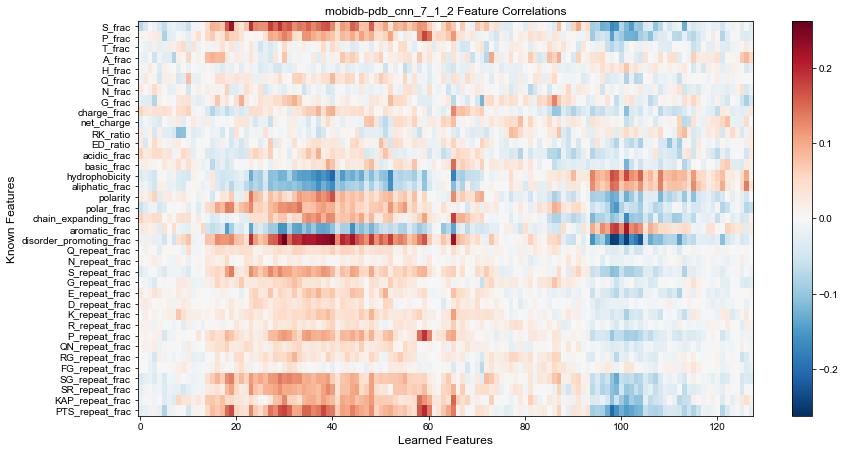

In [13]:
# Plot clustered learned results
fig, ax = plt.subplots(figsize=(12.8, 6.4))
im = ax.imshow(cluster_x_array.transpose(), vmin=-vext, vmax=vext, cmap='RdBu_r',
               aspect='auto', interpolation='none')
ax.set_xlabel('Learned Features', fontsize=12)
ax.set_ylabel('Known Features', fontsize=12)
ax.set_yticks(range(len(known_feature_names)), known_feature_names, fontsize=10)
ax.set_title(f"{model_name} Feature Correlations")
fig.colorbar(im)

fig.savefig(f"{save_path}{model_name}_re_win{known_window}_cluster_x_corr_matrix.png", dpi=300);

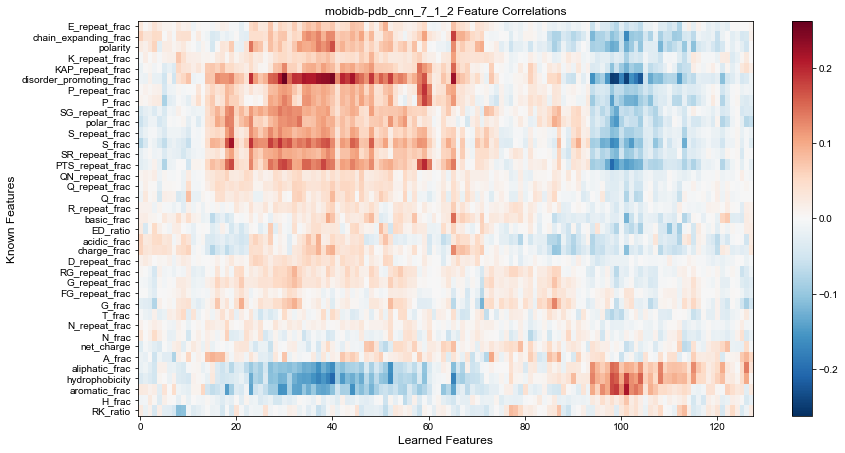

In [14]:
# Plot clustered learned and known results
fig, ax = plt.subplots(figsize=(12.8, 6.4))
im = ax.imshow(cluster_xy_array.transpose(), vmin=-vext, vmax=vext, cmap='RdBu_r',
               aspect='auto', interpolation='none')
ax.set_xlabel('Learned Features', fontsize=12)
ax.set_ylabel('Known Features', fontsize=12)
ax.set_yticks(range(len(known_feature_names)), known_feature_names[known_tip_order], fontsize=10)
ax.set_title(f"{model_name} Feature Correlations")
fig.colorbar(im)

fig.savefig(f"{save_path}{model_name}_re_win{known_window}_cluster_xy_corr_matrix.png", dpi=300);

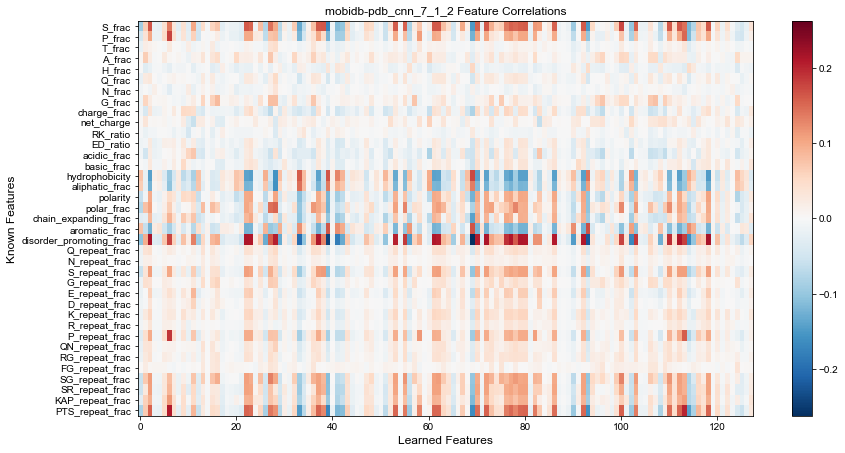

In [15]:
# Plot unclustered trained results
fig, ax = plt.subplots(figsize=(12.8, 6.4))
im = ax.imshow(trained_corr_matrix.transpose(), vmin=-vext, vmax=vext, cmap='RdBu_r',
               aspect='auto', interpolation='none')
ax.set_xlabel('Learned Features', fontsize=12)
ax.set_ylabel('Known Features', fontsize=12)
ax.set_yticks(range(len(known_feature_names)), known_feature_names, fontsize=10)
ax.set_title(f"{model_name} Feature Correlations")
fig.colorbar(im)

fig.savefig(f"{save_path}{model_name}_re_win{known_window}_unclustered_trained_corr_matrix.png", dpi=300);

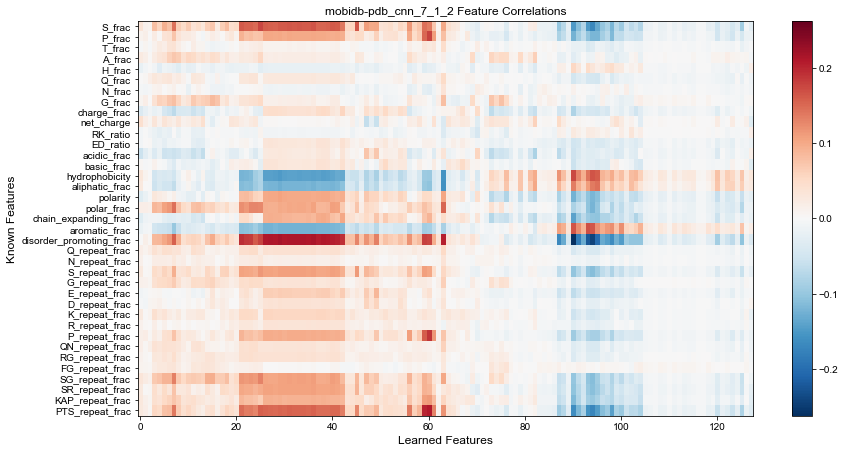

In [16]:
# Plot clustered learned trained results
fig, ax = plt.subplots(figsize=(12.8, 6.4))
im = ax.imshow(trained_cluster_x_array.transpose(), vmin=-vext, vmax=vext, cmap='RdBu_r',
               aspect='auto', interpolation='none')
ax.set_xlabel('Learned Features', fontsize=12)
ax.set_ylabel('Known Features', fontsize=12)
ax.set_yticks(range(len(known_feature_names)), known_feature_names, fontsize=10)
ax.set_title(f"mobidb-pdb_cnn_{model_acc} Feature Correlations")
fig.colorbar(im)

fig.savefig(f"{save_path}{model_name}_re_win{known_window}_cluster_x_trained_corr_matrix.png", dpi=300);

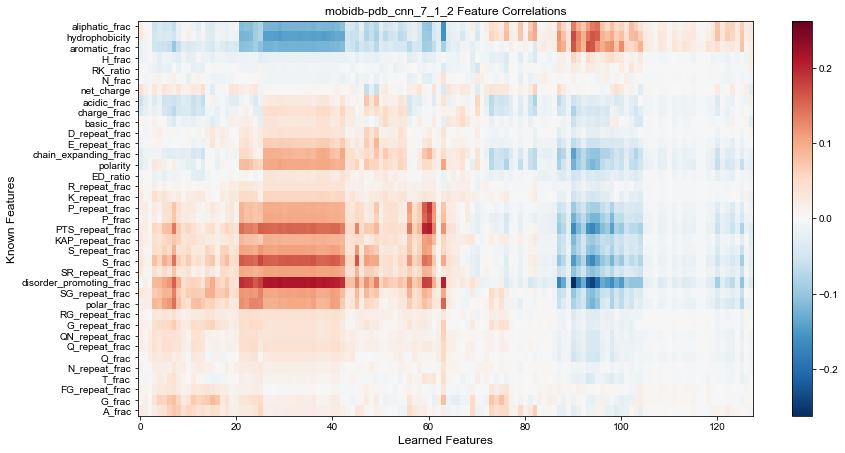

In [17]:
# Plot clustered learned and known trained results
fig, ax = plt.subplots(figsize=(12.8, 6.4))
im = ax.imshow(trained_cluster_xy_array.transpose(), vmin=-vext, vmax=vext, cmap='RdBu_r',
               aspect='auto', interpolation='none')
ax.set_xlabel('Learned Features', fontsize=12)
ax.set_ylabel('Known Features', fontsize=12)
ax.set_yticks(range(len(known_feature_names)), known_feature_names[trained_known_tip_order], fontsize=10)
ax.set_title(f"{model_name} Feature Correlations")
fig.colorbar(im)

fig.savefig(f"{save_path}{model_name}_re_win{known_window}_cluster_xy_trained_corr_matrix.png", dpi=300);

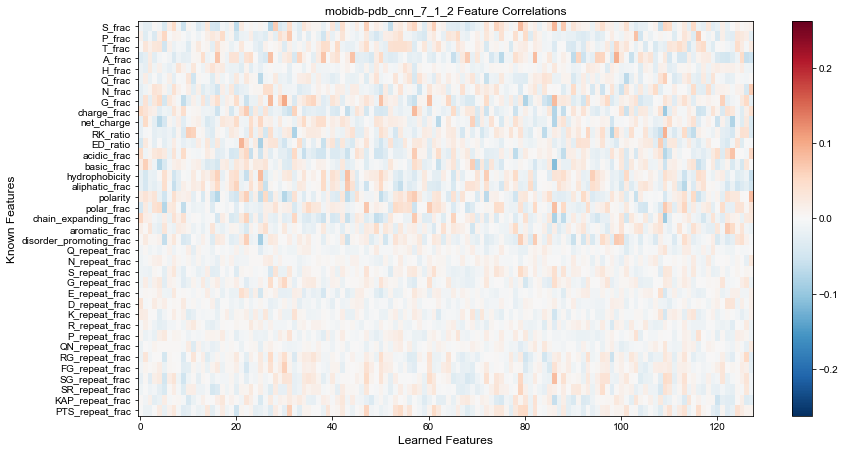

In [18]:
# Plot unclustered untrained results
fig, ax = plt.subplots(figsize=(12.8, 6.4))
im = ax.imshow(untrained_corr_matrix.transpose(), vmin=-vext, vmax=vext, cmap='RdBu_r',
               aspect='auto', interpolation='none')
ax.set_xlabel('Learned Features', fontsize=12)
ax.set_ylabel('Known Features', fontsize=12)
ax.set_yticks(range(len(known_feature_names)), known_feature_names, fontsize=10)
ax.set_title(f"{model_name} Feature Correlations")
fig.colorbar(im)

fig.savefig(f"{save_path}{model_name}_re_win{known_window}_unclustered_untrained_corr_matrix.png", dpi=300);

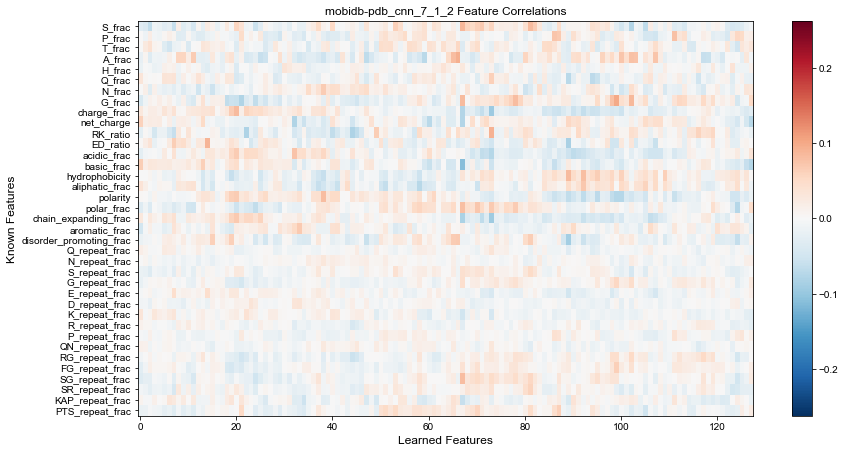

In [19]:
# Plot clustered learned untrained results
fig, ax = plt.subplots(figsize=(12.8, 6.4))
im = ax.imshow(untrained_cluster_x_array.transpose(), vmin=-vext, vmax=vext, cmap='RdBu_r',
               aspect='auto', interpolation='none')
ax.set_xlabel('Learned Features', fontsize=12)
ax.set_ylabel('Known Features', fontsize=12)
ax.set_yticks(range(len(known_feature_names)), known_feature_names, fontsize=10)
ax.set_title(f"mobidb-pdb_cnn_{model_acc} Feature Correlations")
fig.colorbar(im)

fig.savefig(f"{save_path}{model_name}_re_win{known_window}_cluster_x_untrained_corr_matrix.png", dpi=300);

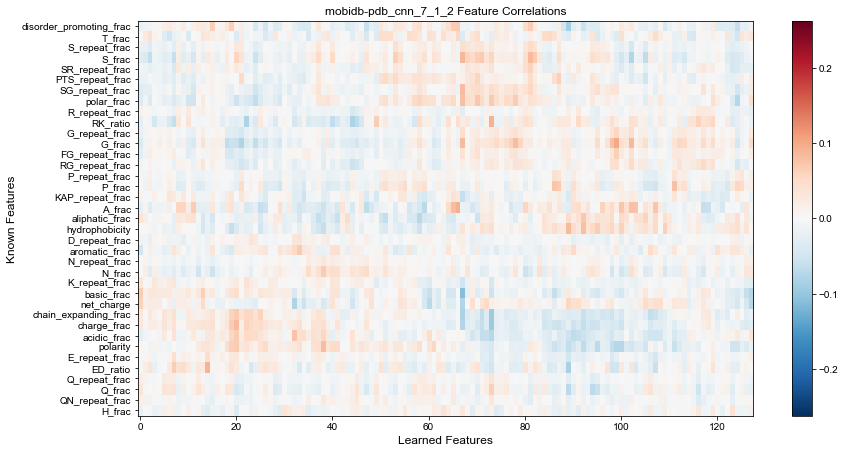

In [20]:
# Plot clustered learned and known untrained results
fig, ax = plt.subplots(figsize=(12.8, 6.4))
im = ax.imshow(untrained_cluster_xy_array.transpose(), vmin=-vext, vmax=vext, cmap='RdBu_r',
               aspect='auto', interpolation='none')
ax.set_xlabel('Learned Features', fontsize=12)
ax.set_ylabel('Known Features', fontsize=12)
ax.set_yticks(range(len(known_feature_names)), known_feature_names[untrained_known_tip_order], fontsize=10)
ax.set_title(f"{model_name} Feature Correlations")
fig.colorbar(im)

fig.savefig(f"{save_path}{model_name}_re_win{known_window}_cluster_xy_untrained_corr_matrix.png", dpi=300);